In [4]:
# ------------------------------------------------
# Script for tinkering and development
# Full name: 3d_revised_grid_reflecting_version3
# ("3d sphere" in the paper)
# ------------------------------------------------

using StatsBase
using Distributions
using ProgressBars
using Plots

# Input parameters
# ------------------------------------------------

const BURN_IN_GEN_N = 10
const TOTAL_GEN_N = 150

# Max coordinates of the population bounding space
# (population = sphere)
const R_MAX = 28
const R_MAX_BURN_IN = 2

const X_MAX = R_MAX
const Y_MAX = R_MAX
const Z_MAX = R_MAX
#= # (population = cube)
const X_MAX = 5
const Y_MAX = 5
const Z_MAX = 50
const Z_MAX_BURN_IN = 5 =#

const X_START = R_MAX_BURN_IN
const Y_START = R_MAX_BURN_IN
const Z_START = R_MAX_BURN_IN

# Dimensions of the whole space
const X_DIM = 2*X_MAX+1
const Y_DIM = 2*Y_MAX+1
const Z_DIM = 2*Z_MAX+1

# Population parameters
#const INIT_PERSON_N = 30
const DEMES_FULL_AT_START = 5
const K_CAPACITY = 100
const R_PROLIF_RATE = 2
const r_LOG_PROLIF_RATE = log(2)

# Gene parameters
const LOCI_N = 20
const MUT_RATE = 0.05
const M_MIG_RATE = 0.05
const MUT_DELETER_RATE = 0.9
const S_SELECT_COEF = 0.005

0.005

In [2]:
# Main program
# ------------------------------------------------

x_range = (X_MAX+1-X_START):(X_MAX+1+X_START)
y_range = (Y_MAX+1-Y_START):(Y_MAX+1+Y_START)
z_range = (Z_MAX+1-Z_START):(Z_MAX+1+Z_START)
possible_init_coords = [collect(x) for x in Iterators.product(x_range, y_range, z_range)]
init_coords = sample(possible_init_coords,DEMES_FULL_AT_START;replace=false)

world = Array{Array{Array{Float32}}}(undef,X_DIM,Y_DIM,Z_DIM)
sizeof(world)

1481544

In [3]:
for coord in init_coords
    if !isassigned(world,coord...)
        world[coord...] = []
    end
    for i in 1:K_CAPACITY
        push!(world[coord...],ones(LOCI_N*2))
    end
end

possible_dirs = []
for a in -1:1
    for b in -1:1
        for c in -1:1
            push!(possible_dirs, (a, b, c))
        end
    end
end

In [4]:
@inbounds function multi_fitn_in_person(person)
    return prod(person)
end

@inbounds function max_fitn(persons_at_pos)
    return maximum(multi_fitn_in_person.(persons_at_pos))
end

@inbounds function mean_fitn(persons_at_pos)
    return mean(multi_fitn_in_person.(persons_at_pos))
end

@inbounds function mutate(person)
    get_mutation_random = rand(Poisson(MUT_RATE))
    @fastmath @inbounds for _ in 1:get_mutation_random
        pos_alter = sample(1:LOCI_N)
        if rand() < MUT_DELETER_RATE
            person[pos_alter] *= 1 - S_SELECT_COEF
        else
            person[pos_alter] *= 1 + S_SELECT_COEF
        end
    end
end

@inbounds function recombine(person)
    for i in 1:LOCI_N
        lr = rand(1:2)
        person[i] = lr==1 ? person[i] : person[i+LOCI_N]
    end
end

@inbounds function mate_cond(mom_fit,dad_fit,max_fitness)
    return (mom_fit > rand()*max_fitness) & (dad_fit > rand()*max_fitness)
end

@inbounds function mate(person1,person2)
    new_loci = vcat(person1[1:LOCI_N],person2[1:LOCI_N])
    return new_loci
end

mate (generic function with 1 method)

In [5]:
@inbounds function build_next_gen(wld,r_max_migrate)
    # Determine the number of offspring for each deme
    next_gen_pops = zeros(Int16,X_DIM,Y_DIM,Z_DIM)
    next_gen_posits = []
    fill!(next_gen_pops,-1)
    for x in 1:X_DIM,y in 1:Y_DIM,z in 1:Z_DIM # OPTIMISE!!
        if isassigned(world,x,y,z) && length(world[x,y,z])>0
            n_ppl_at_deme = length(world[x,y,z])
            expected_offspring = n_ppl_at_deme * (R_PROLIF_RATE/(1 + (n_ppl_at_deme*(R_PROLIF_RATE-1))/K_CAPACITY))
            next_gen_pops[x,y,z] =  rand(Poisson(expected_offspring))
            if next_gen_pops[x,y,z]>0
                push!(next_gen_posits,[x,y,z])
            end
        end
    end
    

    # Define the world (habitat)
    #wld_next = Array{Person}(undef,sum(next_gen_pops))
    wld_next = Array{Array{Array{Float32}}}(undef,X_DIM,Y_DIM,Z_DIM)
    
    all_birth_count = 0

    # Main generation cycle (algorithm)
    mean_fitn_wld = Array{Float32}(undef,X_DIM,Y_DIM,Z_DIM)
    fill!(mean_fitn_wld,-1)
    pops_wld = zeros(Int32,X_DIM,Y_DIM,Z_DIM)

    for deme in next_gen_posits
        curr_persons_at_pos = wld[deme...]
        mean_fitn_wld[deme...] = mean_fitn(curr_persons_at_pos)
        max_fitness =  max_fitn(curr_persons_at_pos)

        next_generation_size = next_gen_pops[deme...]
        
        if next_generation_size > 0
            birth_count = 0
            while birth_count < next_generation_size
                mom = curr_persons_at_pos[rand(1:end)]
                dad = curr_persons_at_pos[rand(1:end)]
                mom_fit = multi_fitn_in_person(mom)
                dad_fit = multi_fitn_in_person(dad)




                #print(mate_cond(relative_extract_xx_ind,relative_extract_xy_ind,max_fitness))
                if mate_cond(mom_fit,dad_fit,max_fitness)
                    #println(mom)
                    gamete_mom = copy(mom) # technically a person, but we'll only use the first half of loci in the mate function
                    gamete_dad = copy(dad) # technically a person, but we'll only use the first half of loci in the mate function
                    recombine(gamete_mom)
                    recombine(gamete_dad)
                    mutate(gamete_mom)
                    mutate(gamete_dad)
                    mate_result = mate(gamete_mom,gamete_dad)

                    res_x = deme[1]
                    res_y = deme[2]
                    res_z = deme[3]
                    move_z = 0
                    if rand()<M_MIG_RATE
                        dir = sample(possible_dirs)
                        move_x = dir[1]
                        move_y = dir[2]
                        move_z = dir[3]

                        x2 = (deme[1]-X_MAX-1+move_x)*(deme[1]-X_MAX-1+move_x)
                        y2 = (deme[2]-Y_MAX-1+move_y)*(deme[2]-Y_MAX-1+move_y)
                        z2 = (deme[3]-Z_MAX-1+move_z)*(deme[3]-Z_MAX-1+move_z)
                        r2 = x2+y2+z2
                        if r2 > r_max_migrate*r_max_migrate
                            res_x = X_MAX+1-trunc(Int16,(r_max_migrate*r_max_migrate/r2) * move_x)
                            res_y = Y_MAX+1-trunc(Int16,(r_max_migrate*r_max_migrate/r2) * move_y)
                            res_y = Z_MAX+1-trunc(Int16,(r_max_migrate*r_max_migrate/r2) * move_z)
                        else
                            res_x += move_x
                            res_y += move_y
                            res_z += move_z
                        end
                    end

                    if !isassigned(wld_next,res_x,res_y,res_z)
                        wld_next[res_x,res_y,res_z] = []
                    end
                    push!(wld_next[res_x,res_y,res_z],mate_result)

                    birth_count += 1
                    all_birth_count += 1
                end
            end
            pops_wld[deme...] = birth_count
        end
    end
    return wld_next,mean_fitn_wld,pops_wld
end

build_next_gen (generic function with 1 method)

In [6]:
# Iterate the main cycle and save the output
# ------------------------------------------------

meanf_world = Array{Float32}(undef,X_DIM,Y_DIM,Z_DIM,0)
pops_world = Array{Float32}(undef,X_DIM,Y_DIM,Z_DIM,0)

@inbounds for _ in 1:BURN_IN_GEN_N
    global world,meanf,pops = build_next_gen(world,R_MAX_BURN_IN)
    global meanf_world = cat(meanf_world,meanf, dims=4)
    global pops_world = cat(pops_world,pops, dims=4)
    #world = migrate(world,X_MAX_BURN_IN)
end


@inbounds for _ in (BURN_IN_GEN_N+1):TOTAL_GEN_N
    global world,meanf,pops = build_next_gen(world,R_MAX)
    global meanf_world = cat(meanf_world,meanf, dims=4)
    global pops_world = cat(pops_world,pops, dims=4)
    #world = migrate(world,X_MAX)
end

In [2]:
# Check some data
# ------------------------------------------------

using Serialization
meanf_world = deserialize("../data/3d_radial/gridrefl3_noburn_1-meanf.dat")

57×57×57×150 Array{Float32, 4}:
[:, :, 1, 1] =
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  …  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0     -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0     -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0     -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0     -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  …  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0     -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0     -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0     -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0     -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
  ⋮                             ⋮    ⋱                           ⋮    
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0     -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0     -1.0  -1.0  -1.0 

In [5]:
slow_down = 1
gen_start = 1
gen_end = 40
z_slice = 18

@gif for i=gen_start:(gen_end*slow_down-1)
    gen_no = trunc(Int,i/slow_down)+1
    heatmap(pops_world[:,:,z_slice,gen_no],clims=(0,K_CAPACITY),ylabel="z=$z_slice,gen=$gen_no")
end

UndefVarError: UndefVarError: pops_world not defined

┌ Info: Saved animation to C:\Users\Hartree\AppData\Local\Temp\jl_RM9CFS3wlA.gif
└ @ Plots C:\Users\Hartree\.julia\packages\Plots\B5j7d\src\animation.jl:156


Plots.AnimatedGif("C:\\Users\\Hartree\\AppData\\Local\\Temp\\jl_RM9CFS3wlA.gif")
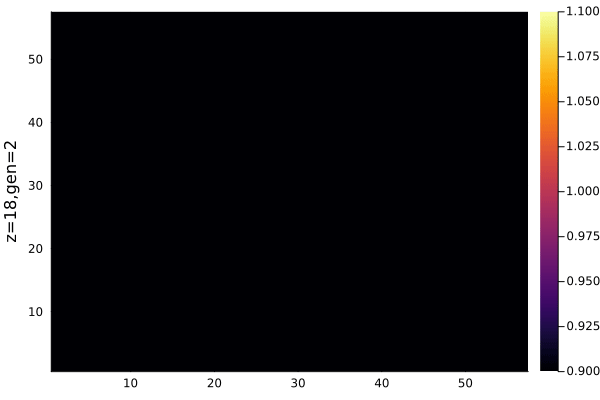

In [8]:
slow_down = 1
gen_start = 1
gen_end = 150
z_slice = 18

@gif for i=gen_start:(gen_end*slow_down-1)
    gen_no = trunc(Int,i/slow_down)+1
    heatmap(meanf_world[:,:,z_slice,gen_no],clims=(0.9,1.1),ylabel="z=$z_slice,gen=$gen_no")
end

In [9]:
using GLMakie

toNaN(x) = x < 0 ? NaN : x

function plot_3d_heatstack(sc,xs,heights,arr3d;minval=0.79,maxval=1.01)
    data = toNaN.(arr3d)
    ax = Axis3(sc[1, 1], aspect=(1, 1, 1), elevation=π/6)

    cr = (minval, maxval) # color range to use for all heatmaps
    for i in 1:size(data, 3)
        hm = GLMakie.heatmap!(ax, xs, xs, data[:, :, i], colorrange=cr,colormap=(:thermal,0.25))
        GLMakie.translate!(hm, 0, 0, heights[i])
        
        i == 1 && Colorbar(sc[1, 2], hm) # add the colorbar once
    end

    GLMakie.zlims!(ax, minimum(heights), maximum(heights))
    sc
end

plot_3d_heatstack (generic function with 1 method)

In [20]:
gen_start = 76
gen_end = 150

scene = Figure()

record(scene, "../data/3d_radial/rrs_gridrefl3_meanf4.mp4") do io
    for i=gen_start:gen_end
        plot_3d_heatstack(scene,1:X_DIM,1:Z_DIM,meanf_world[:,:,:,i],minval=0.05,maxval=1.05)
        recordframe!(io)
        empty!(scene)
    end
end

"../output/3d_radial/rrs_gridrefl3_meanf4.mp4"